We start by adding the necessary folders to the current working path.

In [1]:
# import sys, os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add 'TRA3D' folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/TRA3D")

# Overview

In the following notebook we compute the TRA on the three-dimensional, steady ABC-flow. The velocity field is given as discrete dataset defined over the 3D meshgrid $ [0,2\pi]^3 $. The notebook is structured as follows:

1. Import data from the file 'Channel.h5' stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Define integration scheme for computing flow map (=trajectories) and derivative of flow map (=velocities).
 <br />
5. TRA:

    * Compute velocity along trajectories $ \lbrace \mathbf{\dot{x}}(t_{i}) \rbrace_{i=0}^N $ over the time interval $ [t_0, t_N] $.
    <br />
    
    * Compute $ \mathrm{\overline{TRA}} $ from velocity along trajectories:
    
    \begin{equation}
    \mathrm{\overline{TRA}}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0} \sum_{i = 0}^{N-1} \cos^{-1}\dfrac{\langle \mathbf{\dot{x}}(t_i), \mathbf{\dot{x}}(t_{i+1}) \rangle+\mathrm{v}_0^2}{\sqrt{|\mathbf{\dot{x}}(t_i)|^2+\mathrm{v}_0^2}\sqrt{|\mathbf{\dot{x}}(t_{i+1})|^2+\mathrm{v}_0^2}}
    \end{equation}
    
    $ \mathrm{v}_0 $ is a characteristic velocity. In a steady ABC-flow, $ \mathrm{v}_0 = 0 $.

In [2]:
# import h5py
import h5py

# import numpy
import numpy as np

# Import velocity data from file in data-folder
f = h5py.File('../../../../data/Turbulence/Channel_fine.h5', 'r')

U, V, W = [], [], []

for key in f.keys():
    if key[:8] == "Velocity":
        U.append(f[key][:,:,:,0])
        V.append(f[key][:,:,:,1])
        W.append(f[key][:,:,:,2])

U = np.array(U).transpose(2,3,1,0) # array (NY, NX, NZ, NT)
V = np.array(V).transpose(2,3,1,0) # array (NY, NX, NZ, NT)
W = np.array(W).transpose(2,3,1,0) # array (NY, NX, NZ, NT)
x = f['xcoor'][:].reshape(1,-1) # array (1, NX)
y = f['ycoor'][:].reshape(1,-1) # array (1, NY)
z = f['zcoor'][:].reshape(1,-1) # array (1, NZ)
time_data = np.linspace(0, 25.9935, U.shape[-1], endpoint = True).reshape(1,-1) # array (1, NT)

# Computational parameters

Here we define the computational parameters.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 7 # int

# Periodic boundary conditions
periodic_x = True # bool
periodic_y = False # bool
periodic_z = True # bool
periodic = [periodic_x, periodic_y, periodic_z]

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U).astype(int) # array (NY, NX, NZ)

## Compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z) # array (NY, NX), array (NY, NX, NZ)

# Characteristic velocity
v0 = 1.13 # Centerline velocity of turbulent channel flow

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

# Velocity Interpolation

In order to evaluate the velocity field at arbitrary locations, we interpolate the discrete velocity data. The interpolation with respect to time and space is always linear.

In [4]:
# Initial time
t0 = 0 # float

# Final time
tN = 20 # float

# Time step-size
dt = 0.005 # float

# NOTE: For computing the backward FTLE field tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval
lenT = abs(tN-t0) # float

# boundaries
xmin = 2.26 # float
xmax = 2.36 # float

# check if chosen x-domain is inside the x-grid of the channel flow
assert xmin >= np.min(X) and xmax <= np.max(X)

ymin = 0.33 # float
ymax = 0.47 # float

# check if chosen y-domain is inside the y-grid of the channel flow
assert ymin >= np.min(Y) and ymax <= np.max(Y)

z = 2.55 # float

# check if chosen z is inside the z-grid of the channel flow
assert z >= np.min(Z) and z <= np.max(Z)

dx = 0.005 # float
dy = 0.005 # float

x_domain = np.arange(xmin, xmax, dx) # array (Nx, )
y_domain = np.arange(ymin, ymax, dy) # array (Ny, )

# Resolution of meshgrid
Ny = len(x_domain) # int
Nx = len(y_domain) # int

X_domain, Y_domain = np.meshgrid(x_domain, y_domain) # array (Ny, Nx)

Ny = Y_domain.shape[0] # int
Nx = X_domain.shape[1] # int

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0
W[np.isnan(W)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, Z, U, V, W, time_data)

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object
Interpolant_w = Interpolant[2] # RectangularBivariateSpline-object

# $ \mathrm{\overline{TRA}} $

The computation of the $ \mathrm{\overline{TRA}} $ is not done over the 3D meshgrid but only over the 2D plane specified by $ z = 2.55 $.
We iterate over all initial conditions on the faces of the 2D cross-section and calculate the velocity along the particle trajectories. From the velocity of the trajectories (=time-derivative of flow map) we then compute the $ \mathrm{\overline{TRA}} $.

In [6]:
# Import function to compute trajectory/velocity along trajectory
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# Import function to compute trajectory rotation average (TRA)
from ipynb.fs.defs.TRA import _TRA

# Import package for parallel computing
from joblib import Parallel, delayed

def compute_TRA(x0, y0, z0):
    
    X0 = np.array([x0, y0, z0]) # array (3, Nx*Ny*Nz)
    
    DFDt = integration_dFdt(time, X0, X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady)[1] # array (Nt, 3, Nx*Ny*Nz)
    
    TRA = []
    
    for i in range(DFDt.shape[-1]):
            
        TRA.append(_TRA(DFDt[:,:,i].transpose(), time[-1], v0))
    
    return TRA

# Split x0,y0,z0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [7]:
# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, )

# XY-plane
x0_xy = X_domain.ravel() # array (Nx*Ny, )
y0_xy = Y_domain.ravel() # array (Nx*Ny, )
z0_xy = np.ones(y0_xy.shape[0], )*2*np.pi

x0_batch = list(split(x0_xy, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0_xy, Ncores)) # list (Nx*Ny)
z0_batch = list(split(z0_xy, Ncores)) # list (Nx*Ny)

# Parallel computing
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(compute_TRA)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results of omega computation on xy-plane
TRA = results[0]
for res in results[1:]:
    TRA = np.append(TRA, res, axis = -1)

# Reshape arrays
TRA = np.array(TRA).reshape(Ny,Nx) # array (Ny, Nx)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   2 out of   7 | elapsed:   49.0s remaining:  2.0min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:   50.1s finished


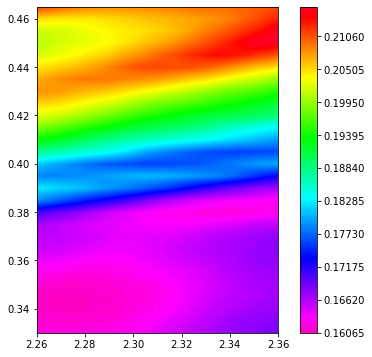

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
cax = ax.contourf(X_domain, Y_domain, TRA, levels = 500, cmap = "gist_rainbow_r")
ax.set_aspect('equal')
plt.colorbar(cax)
plt.show()

Elliptic LCS are visible as convex tubular surfaces with a sharp drop in the $ \mathrm{TRA} $-field. The structures highlighted by the $ \mathrm{LAVD} $-field can directly be compared to those of the [$ \mathrm{\overline{LAVD}}$](../../LAVD3D/Main/LAVDABCsteady.ipynb)-field. Contrary to other commonly used elliptic LCS detection methods such as the $ \mathrm{\overline{LAVD}}$, the features of $ \mathrm{TRA} $ are robust with respect to subsampling as the main vortical flow features are preserved even in a very sparse setting.

# References

[1] Haller, G., Aksamit, N., & Encinas-Bartos, A. P. (2021). Quasi-objective coherent structure diagnostics from single trajectories. Chaos: An Interdisciplinary Journal of Nonlinear Science, 31(4), 043131.